## Download coade and trained weights

In [49]:
!git clone https://github.com/TapasKumarDutta1/circle_detection.git

fatal: destination path 'circle_detection' already exists and is not an empty directory.


In [50]:
!gdown https://drive.google.com/uc?id=1dua5Z4NUhvRtu8wmaN-GqNbl91HUcMFv

Downloading...
From: https://drive.google.com/uc?id=1dua5Z4NUhvRtu8wmaN-GqNbl91HUcMFv
To: /content/weights.pth
100% 5.20M/5.20M [00:00<00:00, 196MB/s]


## Import necessary package and point to code to reuse them.

In [51]:
import sys

sys.path.append("/content/circle_detection")
from generate_dataset import generate
from torchvision import models
from torch import nn
import glob
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import CustomDataset
from torch import optim
from torch.optim import lr_scheduler
import torch
from evaluation import check_iou
from training import train_model
import os
import cv2
from matplotlib import pyplot as plt

generate(10000)

119it [00:00, 1185.15it/s]

Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'


12999it [00:16, 795.84it/s]


## Create training, validation and testing dataset

In [52]:

path_of_the_directory = "/content/train/labels"
ext = ".txt"
files_train = []
loc_x_train = []
loc_y_train = []
radiuses_train = []
for file in os.listdir(path_of_the_directory):
    if file.endswith(ext):
        f = open(os.path.join(path_of_the_directory, file), "r")
        files_train.append(
            os.path.join(path_of_the_directory, file)
            .replace("labels", "images")
            .replace(".txt", "")
        )
        loc_x_train.append(int(f.readline()))
        loc_y_train.append(int(f.readline().replace("\n", "")))
        radiuses_train.append(int(f.readline().replace("\n", "")))


In [53]:
path_of_the_directory = "/content/valid/labels"
ext = ".txt"
files_valid = []
loc_x_valid = []
loc_y_valid = []
radiuses_valid = []
for file in os.listdir(path_of_the_directory):
    if file.endswith(ext):
        f = open(os.path.join(path_of_the_directory, file), "r")
        files_valid.append(
            os.path.join(path_of_the_directory, file)
            .replace("labels", "images")
            .replace(".txt", "")
        )
        loc_x_valid.append(int(f.readline()))
        loc_y_valid.append(int(f.readline().replace("\n", "")))
        radiuses_valid.append(int(f.readline().replace("\n", "")))


In [54]:
path_of_the_directory = "/content/test/labels"
ext = ".txt"
files_test = []
loc_x_test = []
loc_y_test = []
radiuses_test = []
for file in os.listdir(path_of_the_directory):
    if file.endswith(ext):
        f = open(os.path.join(path_of_the_directory, file), "r")
        files_test.append(
            os.path.join(path_of_the_directory, file)
            .replace("labels", "images")
            .replace(".txt", "")
        )
        loc_x_test.append(int(f.readline()))
        loc_y_test.append(int(f.readline().replace("\n", "")))
        radiuses_test.append(int(f.readline().replace("\n", "")))


## Sanity check

Plot one image and reconstruct the image using the labels(x,y and radius)

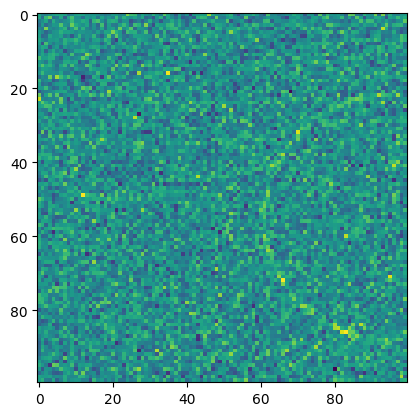

In [55]:
img=np.load("/content/train/images/0.npy")
plt.imshow(img)

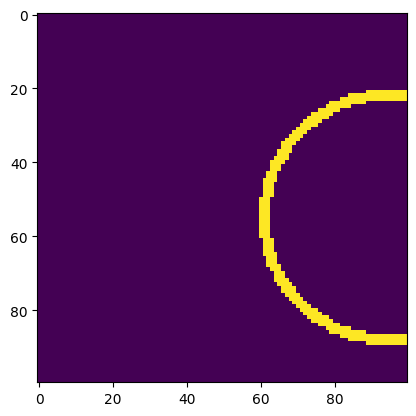

In [56]:
img=np.zeros((100,100))
f = open("/content/train/labels/0.txt", "r")
x=int(f.readline())
y=int(f.readline())
radius=int(f.readline())
cv2.circle(img, (x, y), int(radius), (255,0,0), 2)
plt.imshow(img)

## Trianing

Calculate mean and standard deviation on the triaining set for normalization, create the optimizer, loss, scheduler, and start training.

In [57]:
ls = []
for i in glob.glob("/content/train/images/*.npy"):
    ls.append(np.load(i, allow_pickle=True))
mean, std = np.mean(np.stack(ls)), np.std(np.stack(ls))

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((mean, mean, mean), (std, std, std))]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((mean, mean, mean), (std, std, std))]
)

batch_size = 10

dataset_stages = ["train", "val", "test"]
image_datasets = {
    "train": CustomDataset(
        files_train, loc_x_train, loc_y_train, radiuses_train, batch_size, transform
    ),
    "val": CustomDataset(
        files_valid,
        loc_x_valid,
        loc_y_valid,
        radiuses_valid,
        batch_size,
        test_transform,
    ),
    "test": CustomDataset(
        files_test, loc_x_test, loc_y_test, radiuses_test, batch_size, test_transform
    ),
}

dataloaders = {
    x: DataLoader(
        image_datasets[x],
        batch_size=image_datasets[x].BatchSize,
        shuffle=False,
        num_workers=0,
    )
    for x in dataset_stages
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
model = models.shufflenet_v2_x1_0()
model.fc = nn.Linear(in_features=1024, out_features=3, bias=True)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, "min")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [58]:

model, _ = train_model(
    model,
    dataloaders["train"],
    dataloaders["val"],
    criterion,
    optimizer,
    scheduler,
    device,
    50,
)


100%|██████████| 100/100 [00:02<00:00, 40.23it/s]


Epoch [0], train_loss: 0.0613, val_loss: 0.0083


100%|██████████| 100/100 [00:01<00:00, 51.87it/s]


Epoch [1], train_loss: 0.0079, val_loss: 0.0037


100%|██████████| 100/100 [00:01<00:00, 51.74it/s]


Epoch [2], train_loss: 0.0044, val_loss: 0.0041


100%|██████████| 100/100 [00:02<00:00, 47.92it/s]


Epoch [3], train_loss: 0.0031, val_loss: 0.0018


100%|██████████| 100/100 [00:02<00:00, 38.71it/s]


Epoch [4], train_loss: 0.0031, val_loss: 0.0032


100%|██████████| 100/100 [00:02<00:00, 39.98it/s]


Epoch [5], train_loss: 0.0030, val_loss: 0.0026


100%|██████████| 100/100 [00:01<00:00, 52.55it/s]


Epoch [6], train_loss: 0.0014, val_loss: 0.0016


100%|██████████| 100/100 [00:01<00:00, 52.95it/s]


Epoch [7], train_loss: 0.0010, val_loss: 0.0018


100%|██████████| 100/100 [00:01<00:00, 53.41it/s]


Epoch [8], train_loss: 0.0021, val_loss: 0.0016


100%|██████████| 100/100 [00:01<00:00, 51.63it/s]


Epoch [9], train_loss: 0.0024, val_loss: 0.0021


100%|██████████| 100/100 [00:02<00:00, 44.49it/s]


Epoch [10], train_loss: 0.0011, val_loss: 0.0015


100%|██████████| 100/100 [00:02<00:00, 40.54it/s]


Epoch [11], train_loss: 0.0013, val_loss: 0.0013


100%|██████████| 100/100 [00:02<00:00, 49.72it/s]


Epoch [12], train_loss: 0.0007, val_loss: 0.0011


100%|██████████| 100/100 [00:01<00:00, 50.32it/s]


Epoch [13], train_loss: 0.0005, val_loss: 0.0012


100%|██████████| 100/100 [00:01<00:00, 50.86it/s]


Epoch [14], train_loss: 0.0006, val_loss: 0.0012


100%|██████████| 100/100 [00:01<00:00, 51.28it/s]


Epoch [15], train_loss: 0.0017, val_loss: 0.0021


100%|██████████| 100/100 [00:02<00:00, 43.05it/s]


Epoch [16], train_loss: 0.0011, val_loss: 0.0014


100%|██████████| 100/100 [00:02<00:00, 47.16it/s]


Epoch [17], train_loss: 0.0005, val_loss: 0.0011


100%|██████████| 100/100 [00:02<00:00, 49.48it/s]


Epoch [18], train_loss: 0.0004, val_loss: 0.0011


100%|██████████| 100/100 [00:02<00:00, 41.23it/s]


Epoch [19], train_loss: 0.0011, val_loss: 0.0012


100%|██████████| 100/100 [00:02<00:00, 49.88it/s]


Epoch [20], train_loss: 0.0006, val_loss: 0.0010


100%|██████████| 100/100 [00:01<00:00, 50.27it/s]


Epoch [21], train_loss: 0.0004, val_loss: 0.0007


100%|██████████| 100/100 [00:02<00:00, 47.52it/s]


Epoch [22], train_loss: 0.0007, val_loss: 0.0019


100%|██████████| 100/100 [00:02<00:00, 42.67it/s]


Epoch [23], train_loss: 0.0010, val_loss: 0.0009


100%|██████████| 100/100 [00:01<00:00, 51.71it/s]


Epoch [24], train_loss: 0.0004, val_loss: 0.0008


100%|██████████| 100/100 [00:02<00:00, 49.10it/s]


Epoch [25], train_loss: 0.0003, val_loss: 0.0008


100%|██████████| 100/100 [00:02<00:00, 39.97it/s]


Epoch [26], train_loss: 0.0003, val_loss: 0.0008
Early stopping after 27 epochs without improvement.
Training complete in 19m 43s


In [59]:
model.load_state_dict(torch.load("/content/weights.pth"))
check_iou(model, dataloaders['test'], device)

0.9945

In [60]:
ls=[]
for i in range(50,95,5):
  ls.append(check_iou(model, dataloaders['test'], device,i/100))
np.mean(ls)

0.8625

## Visualization

Plot some of the test images and reconstruct using model's predictions.

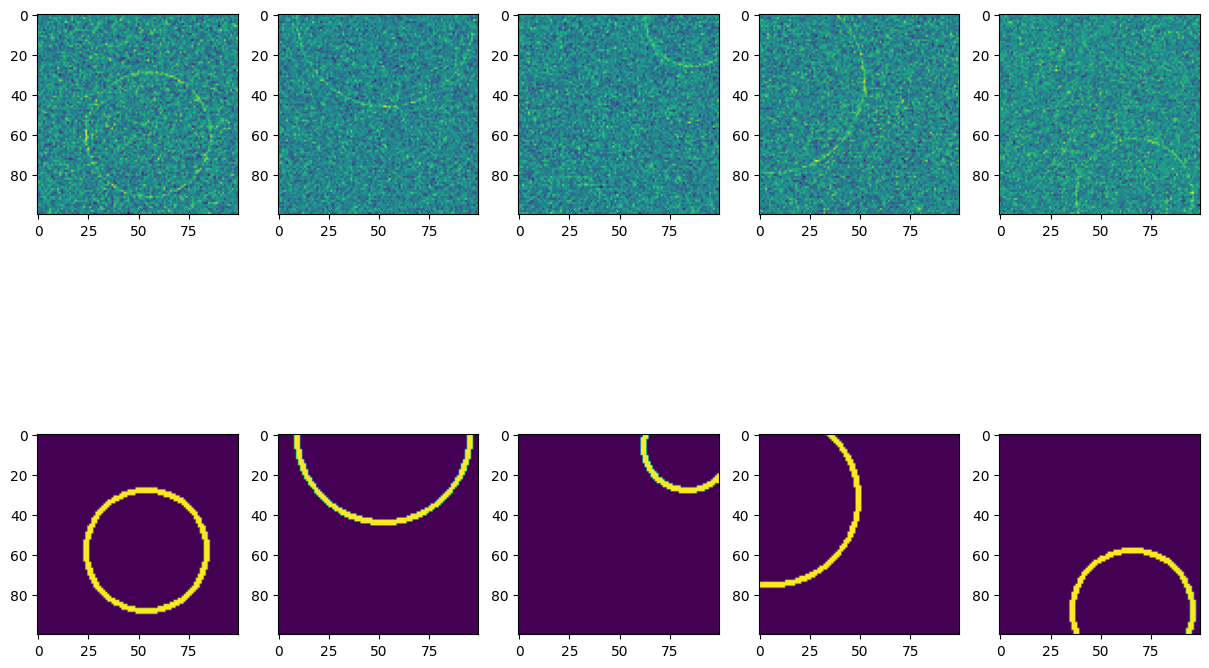

In [61]:
for images,_ in dataloaders['test']:
  break
pred=model(images.to("cuda").float())
fig,ax = plt.subplots(2,5, figsize=(15,10))
for i in range(5):
    ax[0][i].imshow(images[i,0])
    x,y,r=pred[i].detach().cpu().numpy()*[100,100,49]
    x,y,r=int(x),int(y),int(r)
    img=np.zeros((100,100))
    cv2.circle(img, (int(x), int(y)), int(r), (255,0,0), 2)
    ax[1][i].imshow(img)

## Sample Prediction on single generated image

In [62]:
from utils import noisy_circle, iou, CircleParams
img,param=noisy_circle(100,10,50,0.5)
img=(img-np.mean(img))/np.std(img)
pred=model(torch.from_numpy(np.tile(img.reshape(1,1,100,100),(1,3,1,1))).to("cuda").float())
col,row,radius=(pred*torch.from_numpy(np.asarray([[100,100,49]])).to("cuda")).detach().cpu().numpy()[0]
iou(CircleParams(int(row),int(col),int(radius)),param)

0.880091120535946